In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, LdaModel
from sklearn.metrics.pairwise import cosine_similarity

MODEL_DIR = "models_hybrid_lda_w2v"
GT_DIR = "ground_truth_100queries"
OUTPUT_DIR = "evaluation_results_100queries"
os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
chdf = pd.read_csv(os.path.join(MODEL_DIR, "chunks_meta.csv"))
w2v_chunks = Word2Vec.load(os.path.join(MODEL_DIR, "word2vec_chunks.model"))
lda_chunks = LdaModel.load(os.path.join(MODEL_DIR, "lda_model_chunks.gensim"))
with open(os.path.join(MODEL_DIR, "lda_dictionary_chunks.pkl"), "rb") as f:
    dictionary_chunks = pickle.load(f)
chunkvecs_w2v = np.load(os.path.join(MODEL_DIR, "chunkvecs_w2v.npy"))
chunkvecs_lda = np.load(os.path.join(MODEL_DIR, "chunkvecs_lda.npy"))

LDA_TOPICS = lda_chunks.num_topics
W2V_DIM = chunkvecs_w2v.shape[1]


In [3]:
gt_df = pd.read_csv(os.path.join(GT_DIR, "queries_ground_truth_100queries.csv"))

gt_df['relevant_chunks'] = gt_df['relevant_chunk_indices'].apply(
    lambda x: [int(i) for i in str(x).split(',')] if pd.notna(x) else []
)

ground_truth_dict = {}
for _, row in gt_df.iterrows():
    ground_truth_dict[int(row['query_id'])] = row['relevant_chunks']


In [4]:
TOKEN_RE = re.compile(r"[a-zA-Z][a-zA-Z0-9\-]+")

def tokenize(text):
    if text is None:
        return []
    if isinstance(text, (list, tuple)):
        text = " ".join(map(str, text))
    try:
        text = text.lower()
    except Exception:
        text = str(text).lower()
    toks = TOKEN_RE.findall(text)
    return [t for t in toks if 2 <= len(t) <= 40]

def docvec_w2v(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv.key_to_index]
    if not vecs:
        return np.zeros(model.vector_size, dtype=np.float32)
    v = np.mean(vecs, axis=0).astype(np.float32)
    n = np.linalg.norm(v) + 1e-12
    return v / n

def dense_topic_vec(bow, lda_model, K):
    dist = np.zeros(K, dtype=np.float32)
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0.0):
        if 0 <= tid < K:
            dist[tid] = prob
    n = np.linalg.norm(dist) + 1e-12
    return dist / n

def query_to_w2v_vec(q, model):
    toks = tokenize(q)
    return docvec_w2v(toks, model).reshape(1, -1)

def query_to_lda_vec(q, dictionary, lda_model, K):
    toks = tokenize(q)
    bow = dictionary.doc2bow(toks)
    return dense_topic_vec(bow, lda_model, K).reshape(1, -1)

def minmax(x):
    mn, mx = float(np.min(x)), float(np.max(x))
    if mx - mn < 1e-12:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

def hybrid_search_chunks(query, topk=50, alpha=0.5, min_score=0.0):
    q_w2v = query_to_w2v_vec(query, w2v_chunks)
    q_lda = query_to_lda_vec(query, dictionary_chunks, lda_chunks, LDA_TOPICS)
    
    s_w2v = cosine_similarity(q_w2v, chunkvecs_w2v)[0]
    s_lda = cosine_similarity(q_lda, chunkvecs_lda)[0]
    
    s_w2v = minmax(s_w2v)
    s_lda = minmax(s_lda)
    score = alpha * s_w2v + (1 - alpha) * s_lda
    
    sorted_idx = np.argsort(-score)[:topk]
    
    return sorted_idx, score[sorted_idx]


In [5]:
def precision_at_k(retrieved, relevant, k):
    retrieved_k = set(retrieved[:k])
    relevant_set = set(relevant)
    if len(retrieved_k) == 0:
        return 0.0
    return len(retrieved_k & relevant_set) / len(retrieved_k)

def recall_at_k(retrieved, relevant, k):
    retrieved_k = set(retrieved[:k])
    relevant_set = set(relevant)
    if len(relevant_set) == 0:
        return 0.0
    return len(retrieved_k & relevant_set) / len(relevant_set)

def f1_at_k(retrieved, relevant, k):
    p = precision_at_k(retrieved, relevant, k)
    r = recall_at_k(retrieved, relevant, k)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def mean_metric_at_k(all_retrieved, all_relevant, k, metric_func):
    metrics = []
    for query_id in all_retrieved.keys():
        if query_id in all_relevant:
            m = metric_func(all_retrieved[query_id], all_relevant[query_id], k)
            metrics.append(m)
    return np.mean(metrics) if metrics else 0.0


In [7]:
alpha_values = [0.0, 0.3, 0.5, 0.7, 1.0]
k_values = [5, 10, 20, 50]

results = {}

for alpha in alpha_values:
    retrieved_results = {}
    
    for _, row in tqdm(gt_df.iterrows(), total=len(gt_df), desc=f"Alpha {alpha}"):
        query_id = int(row['query_id'])
        query_text = row['query_text']
        
        chunk_indices, scores = hybrid_search_chunks(query_text, topk=50, alpha=alpha)
        retrieved_results[query_id] = chunk_indices.tolist()
    
    results[alpha] = {}
    for k in k_values:
        results[alpha][f'P@{k}'] = mean_metric_at_k(retrieved_results, ground_truth_dict, k, precision_at_k)
        results[alpha][f'R@{k}'] = mean_metric_at_k(retrieved_results, ground_truth_dict, k, recall_at_k)
        results[alpha][f'F1@{k}'] = mean_metric_at_k(retrieved_results, ground_truth_dict, k, f1_at_k)


Alpha 1.0: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


In [8]:
summary_rows = []
for alpha in alpha_values:
    for k in k_values:
        summary_rows.append({
            'alpha': alpha,
            'k': k,
            'P@k': results[alpha][f'P@{k}'],
            'R@k': results[alpha][f'R@{k}'],
            'F1@k': results[alpha][f'F1@{k}']
        })

summary_df = pd.DataFrame(summary_rows)

output_csv = os.path.join(OUTPUT_DIR, "evaluation_results.csv")
summary_df.to_csv(output_csv, index=False)


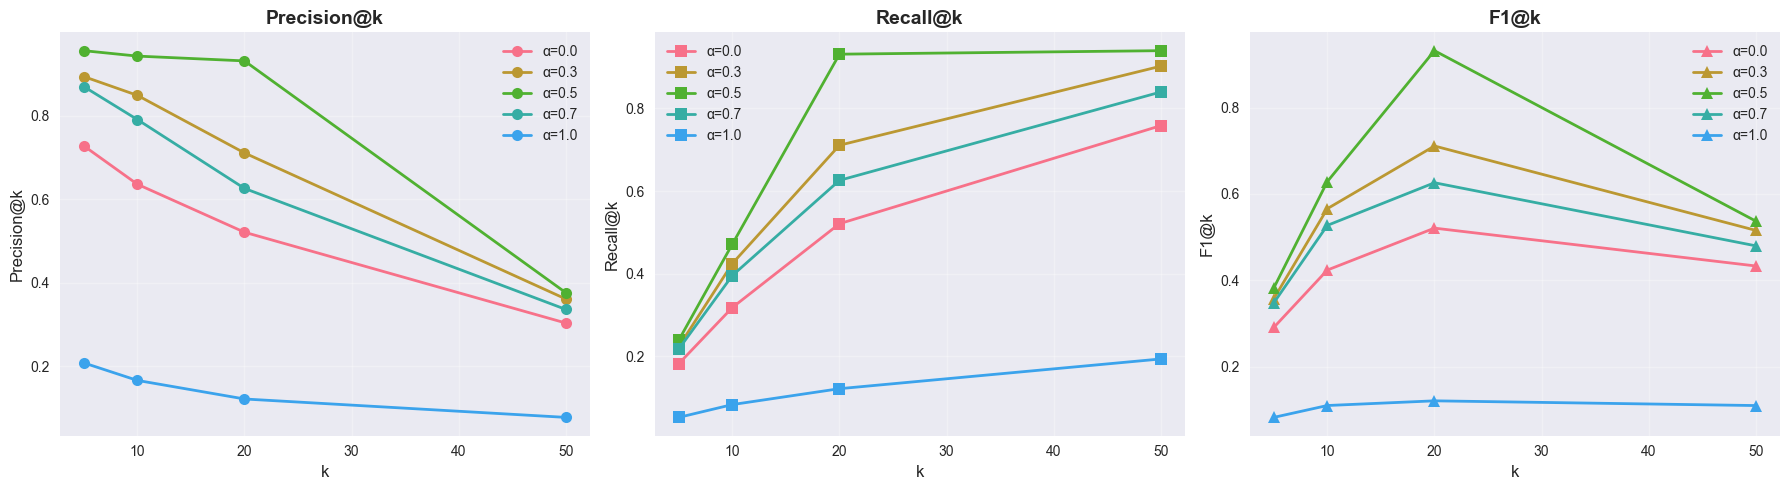

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
for alpha in alpha_values:
    p_values = [results[alpha][f'P@{k}'] for k in k_values]
    ax.plot(k_values, p_values, marker='o', label=f'α={alpha}', linewidth=2, markersize=8)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Precision@k', fontsize=12)
ax.set_title('Precision@k', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
for alpha in alpha_values:
    r_values = [results[alpha][f'R@{k}'] for k in k_values]
    ax.plot(k_values, r_values, marker='s', label=f'α={alpha}', linewidth=2, markersize=8)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Recall@k', fontsize=12)
ax.set_title('Recall@k', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
for alpha in alpha_values:
    f1_values = [results[alpha][f'F1@{k}'] for k in k_values]
    ax.plot(k_values, f1_values, marker='^', label=f'α={alpha}', linewidth=2, markersize=8)
ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('F1@k', fontsize=12)
ax.set_title('F1@k', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_plot = os.path.join(OUTPUT_DIR, "metrics_comparison.png")
plt.savefig(output_plot, dpi=300, bbox_inches='tight')
plt.show()


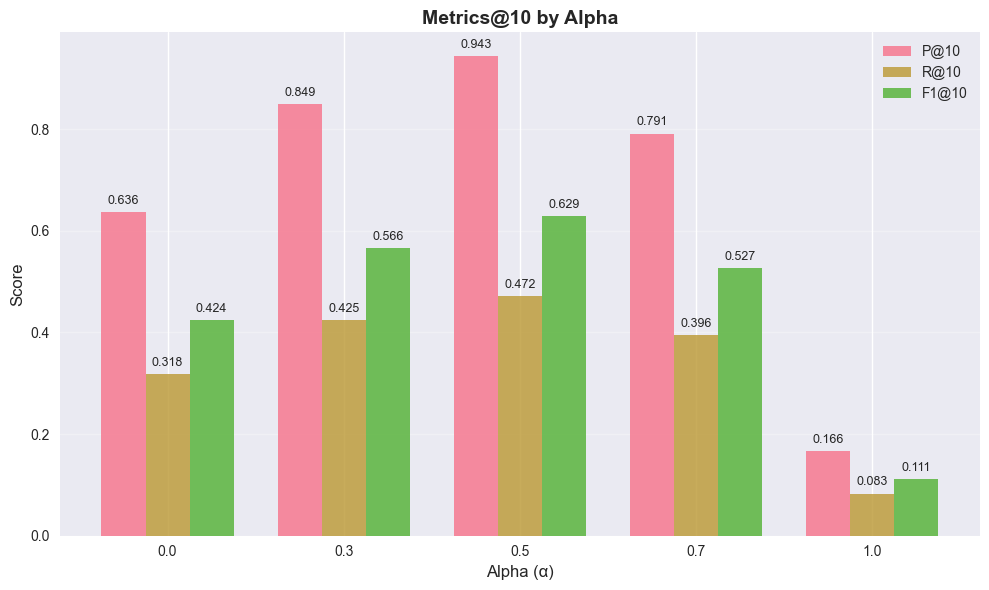

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(alpha_values))
width = 0.25

p10_values = [results[alpha]['P@10'] for alpha in alpha_values]
r10_values = [results[alpha]['R@10'] for alpha in alpha_values]
f10_values = [results[alpha]['F1@10'] for alpha in alpha_values]

ax.bar(x - width, p10_values, width, label='P@10', alpha=0.8)
ax.bar(x, r10_values, width, label='R@10', alpha=0.8)
ax.bar(x + width, f10_values, width, label='F1@10', alpha=0.8)

ax.set_xlabel('Alpha (α)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Metrics@10 by Alpha', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{a:.1f}' for a in alpha_values])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for i, (p, r, f) in enumerate(zip(p10_values, r10_values, f10_values)):
    ax.text(i - width, p + 0.01, f'{p:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(i, r + 0.01, f'{r:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width, f + 0.01, f'{f:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
output_plot2 = os.path.join(OUTPUT_DIR, "alpha_comparison_k10.png")
plt.savefig(output_plot2, dpi=300, bbox_inches='tight')
plt.show()


In [11]:
best_results = {}
for metric_name in ['P@10', 'R@10', 'F1@10']:
    best_alpha = max(alpha_values, key=lambda a: results[a][metric_name])
    best_score = results[best_alpha][metric_name]
    best_results[metric_name] = {'alpha': best_alpha, 'score': best_score}

output_json = os.path.join(OUTPUT_DIR, "evaluation_results.json")
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump({
        'results': {str(k): v for k, v in results.items()},
        'best_results': {k: {'alpha': v['alpha'], 'score': float(v['score'])} 
                        for k, v in best_results.items()},
        'alpha_values': alpha_values,
        'k_values': k_values
    }, f, indent=2, ensure_ascii=False)


In [12]:
best_alpha = best_results['F1@10']['alpha']

detailed_results = []
for _, row in gt_df.iterrows():
    query_id = int(row['query_id'])
    query_text = row['query_text']
    relevant_chunks = ground_truth_dict[query_id]
    
    chunk_indices, scores = hybrid_search_chunks(query_text, topk=50, alpha=best_alpha)
    retrieved_chunks = chunk_indices.tolist()
    
    metrics_row = {'query_id': query_id, 'query_text': query_text}
    for k in k_values:
        metrics_row[f'P@{k}'] = precision_at_k(retrieved_chunks, relevant_chunks, k)
        metrics_row[f'R@{k}'] = recall_at_k(retrieved_chunks, relevant_chunks, k)
        metrics_row[f'F1@{k}'] = f1_at_k(retrieved_chunks, relevant_chunks, k)
    
    detailed_results.append(metrics_row)

detailed_df = pd.DataFrame(detailed_results)

output_detailed = os.path.join(OUTPUT_DIR, f"detailed_results_alpha_{best_alpha}.csv")
detailed_df.to_csv(output_detailed, index=False)


In [13]:
top_queries = detailed_df.nlargest(10, 'F1@10')[['query_id', 'query_text', 'P@10', 'R@10', 'F1@10']]
worst_queries = detailed_df.nsmallest(10, 'F1@10')[['query_id', 'query_text', 'P@10', 'R@10', 'F1@10']]


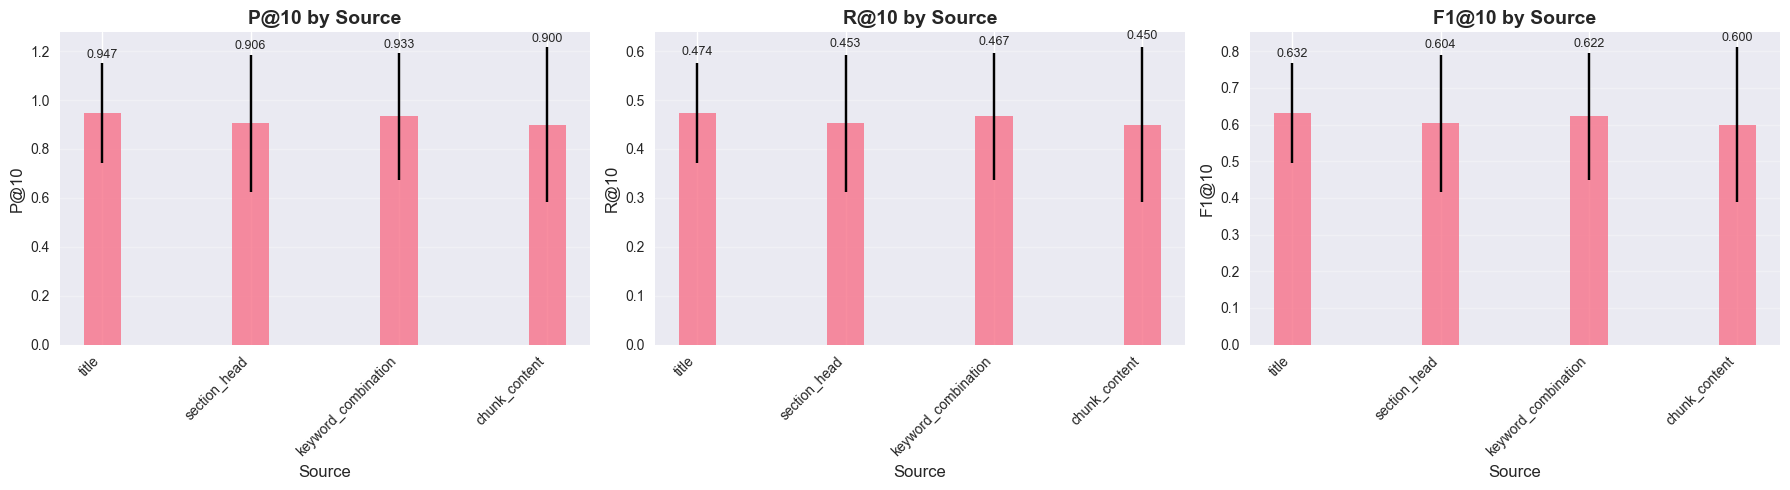

In [14]:
detailed_df_with_source = detailed_df.merge(
    gt_df[['query_id', 'source']], 
    on='query_id', 
    how='left'
)

source_stats = detailed_df_with_source.groupby('source').agg({
    'P@10': ['mean', 'std'],
    'R@10': ['mean', 'std'],
    'F1@10': ['mean', 'std']
}).round(4)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sources = detailed_df_with_source['source'].unique()
x = np.arange(len(sources))
width = 0.25

for i, metric in enumerate(['P@10', 'R@10', 'F1@10']):
    ax = axes[i]
    means = [detailed_df_with_source[detailed_df_with_source['source'] == s][metric].mean() 
             for s in sources]
    stds = [detailed_df_with_source[detailed_df_with_source['source'] == s][metric].std() 
            for s in sources]
    
    ax.bar(x, means, width, yerr=stds, alpha=0.8, capsize=5)
    ax.set_xlabel('Source', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} by Source', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sources, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    for j, (m, s) in enumerate(zip(means, stds)):
        ax.text(j, m + s + 0.01, f'{m:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
output_plot3 = os.path.join(OUTPUT_DIR, "metrics_by_source.png")
plt.savefig(output_plot3, dpi=300, bbox_inches='tight')
plt.show()
